# Homework 2 Re-Do

In [1]:
import pandas as pd
import numpy as np
from Binomial_Fixed.ficcvol import *
from Binomial_Fixed.binomial import *
from Binomial_Fixed.ratecurves import *
import scipy
from scipy.optimize import fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
from Binomial_Fixed import treasury_cmds

# Homework 2

## FINM 37500 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Stripping the Caps

The file `data/cap_curves_2023-03-31.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.
* the details of the data prep can be found in `build_data/Process Cap Quotes`.

## Context

Recall that 
* a cap is made of caplets with $.5\le \tau \le T$
* the flat volatility at $T$ is input for every caplet corresponding to the cap of $T$.
* use Black's formula for this calculation.
* in Black's formula, use $T-.25$ as the rate for the caplet is determined one period before it is paid.

As for the cap parameters,
* the cap's strike is the swap rate with the same tenor. So the $T=2$ cap is struck at the swap rate of $\tau=2$.
* the notional of the cap is $100.
* the payoff of each caplet is

$$\frac{100}{n}\max(r-K,0)$$

where $n$ is the frequency; here $n=4$.

Thus, the corresponding value in Black's fomula for a caplet is
$$P^{\text{cap}}_{T} = \frac{100}{n} \sum_{\tau=.5}^T B_{\text{call}}(\overline{\sigma}_T, \tau-.25, K=s_T, f_{\tau}, Z_{\tau})$$
Note here that for every caplet in cap $T$, we plug in the same 
* flat vol with tenor $T$.
* strike which is the swap rate of maturity $T$.

The notation above is using subscripts for tenor / maturity rather than time period. That is, $Z_{\tau}$ denotes $Z(t, t+\tau)$ which is today's discount factor for maturity $\tau$. Similarly for the swap rate of tenor $T$, denoted above $s_T$ and forward rate $f(t,t+\tau-.25, t+\tau)$ denoted simply $f

### Black's Formula
Recall Black's formula:

$$\begin{align}
B_{\text{call}}(\sigma, T, K, f, Z) = &\; Z\left[f\mathcal{N}\left(d_1\right) - K\mathcal{N}(d_2)\right] \\
d_1 =& \frac{\ln\left(\frac{f}{K}\right) + \frac{\sigma^2}{2}T}{\sigma\sqrt{T}} \\
d_2 =& d_1 -\sigma\sqrt{T}
\end{align}
$$



## 1.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

In [2]:

cap_curves = pd.read_excel('C:/Users/dcste/OneDrive/Fixed_Income_Derivatives/finm-fiderivs-2023\data\cap_curves_2023-03-31.xlsx')

In [3]:
def CAP_Floor(spot_rate, strike_rate, volatility,discount,T,dt = .25,N = 1, caplet = True):
    """
    spot_rate : set equal to the forward rate
    strike_rate: set equal to the swap rate
    volatility: flat vol
    discount = discount factor
    T = time to maturity
    dt:  frequency of payments
    N: Notional Value
    """
    d1 = (np.log(spot_rate/strike_rate) + (volatility**2/2)*T)/(volatility*np.sqrt(T))
    d2 = d1 - volatility*np.sqrt(T)
    if caplet == True:
        return N*dt*(discount*(spot_rate*norm.cdf(d1) - strike_rate*norm.cdf(d2)))
    if not caplet:
        return N*dt(discount*(strike_rate*norm.cdf(-d2) - spot_rate*norm.cdf(-d1)))


In [4]:
cap_curves.head()

,tenor,swap rates,discounts,forwards,flat vols
0,0.25,0.049149,0.987862,NaN,NaN
1,0.50,0.049097,0.975896,0.049045,0.219491
2,0.75,0.048306,0.964628,0.046724,0.303075
3,1.00,0.047170,0.954188,0.043764,0.369483
4,1.25,0.045246,0.945312,0.037559,0.420688


In [5]:
cap_curves.columns

Index(['tenor', 'swap rates', 'discounts', 'forwards', 'flat vols'], dtype='object')

**Important**

- Calculate the CAPs with constant flat volatility and with the strike equal to the present swap rate

In [6]:
for i in range(1,len(cap_curves)):
    price = 0
    for j in range(1,i+1):
        price += CAP_Floor(spot_rate=cap_curves.loc[j,'forwards'],strike_rate=cap_curves.loc[i,'swap rates'],volatility=cap_curves.loc[i,'flat vols'],\
            discount = cap_curves.loc[j,'discounts'],T = cap_curves.loc[j,'tenor']-.25, dt = .25, N =100, caplet = True)
    cap_curves.loc[i,'CAP']  = price

In [7]:
cap_curves.head()

,tenor,swap rates,discounts,forwards,flat vols,CAP
0,0.25,0.049149,0.987862,NaN,NaN,NaN
1,0.50,0.049097,0.975896,0.049045,0.219491,0.051758
2,0.75,0.048306,0.964628,0.046724,0.303075,0.160980
3,1.00,0.047170,0.954188,0.043764,0.369483,0.324507
4,1.25,0.045246,0.945312,0.037559,0.420688,0.523376


## 1.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

In [8]:

cap_curves['CAPLET'] = cap_curves['CAP'].diff()
cap_curves.loc[1,'CAPLET'] = cap_curves.loc[1,'CAP'] 
cap_curves.head(3)


,tenor,swap rates,discounts,forwards,flat vols,CAP,CAPLET
0,0.25,0.049149,0.987862,NaN,NaN,NaN,NaN
1,0.50,0.049097,0.975896,0.049045,0.219491,0.051758,0.051758
2,0.75,0.048306,0.964628,0.046724,0.303075,0.160980,0.109222


In [9]:
for i in range(1,len(cap_curves)):

    vol_wrapper = lambda sigma : cap_curves.loc[i,'CAPLET'] - CAP_Floor(discount=cap_curves.loc[i,'discounts'],T = cap_curves.loc[i,'tenor']-.25,spot_rate=cap_curves.loc[i,'forwards'],\
        strike_rate = cap_curves.loc[i,'swap rates'],dt = .25, N = 100, volatility = sigma)
    cap_curves.loc[i,'Forward_Vol'] = fsolve(vol_wrapper,.2)

In [67]:
caps_us_fwd_vol = pd.DataFrame(dtype = float, index = cap_curves.index, columns=['CAP'])
for i in range(1,len(caps_us_fwd_vol)):
    price = 0
    for j in range(1,i+1):
        price += CAP_Floor(spot_rate=cap_curves.loc[j,'forwards'],strike_rate=cap_curves.loc[i,'swap rates'],volatility=cap_curves.loc[j,'Forward_Vol'],\
            discount = cap_curves.loc[j,'discounts'],T = cap_curves.loc[j,'tenor']-.25, dt = .25, N =100, caplet = True)
    caps_us_fwd_vol.loc[i,'CAP']  = price


In [69]:
caps_us_fwd_vol.head()

,CAP
0,NaN
1,0.051758
2,0.170701
3,0.361537
4,0.630645


In [65]:
cap_curves.head()

,tenor,swap rates,discounts,forwards,flat vols,CAP,CAPLET,Forward_Vol
0,0.25,0.049149,0.987862,NaN,NaN,NaN,NaN,NaN
1,0.50,0.049097,0.975896,0.049045,0.219491,0.051758,0.051758,0.219491
2,0.75,0.048306,0.964628,0.046724,0.303075,0.160980,0.109222,0.395405
3,1.00,0.047170,0.954188,0.043764,0.369483,0.324507,0.163527,0.543084
4,1.25,0.045246,0.945312,0.037559,0.420688,0.523376,0.198868,0.736688


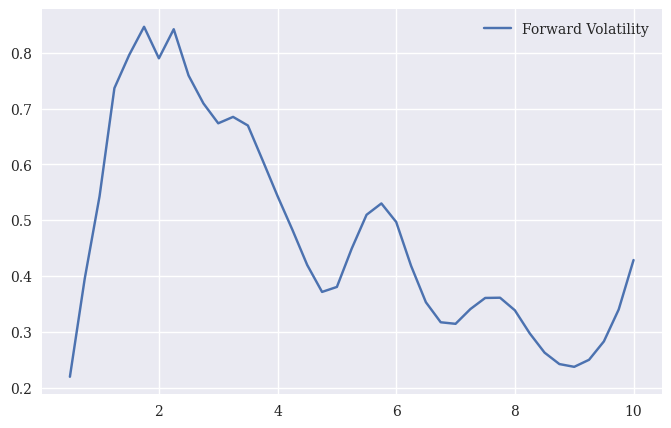

In [10]:
plt.figure(figsize=(8,5))
plt.plot(cap_curves.tenor, cap_curves.Forward_Vol, label = 'Forward Volatility')
plt.legend(loc = 0)

# Pricing Callable Bond

## 2.1 Calibrate a BDT model 

Use data from the file `data/cap_curves_2023-03-31.xlsx` to calibrate the model.
* Use the forward volatilities calculated in 1.2 to calibrate $\sigma$ at each step. 
    * If you could not solve 1.2, then use $\sigma=.35$ at every step.
    * You do not have a forward volatility at $\tau=.25$ given there is no caplet there. For purposes of the BDT model, assume $\sigma_{.25}$ is equal to the forward volatility at the first estimated period, $t=0.50$. That is, use the first estimated forward vol (corresponding to $\tau=.50$ for both $t=.25$ and $t=.50$ in the BDT tree.
    
* Given these $\sigma$ parameters, calibrate the series of $\theta$ to fit the zero-coupon bond prices given by `discounts` (multiplied by 100).

Display the series of $\theta$ parameters.

Display the tree of rates from $0\le t \le 10$.

In [11]:
curves = cap_curves.copy().set_index('tenor')
curves.loc[.25,'Forward_Vol'] = curves.loc[.50,'Forward_Vol']
quotes = curves['discounts']*100
vols = curves['Forward_Vol']


In [12]:
theta , ratetree = estimate_theta(vols, quotes)


In [13]:
vols.head()

tenor
0.25    0.219491
0.50    0.219491
0.75    0.395405
1.00    0.543084
1.25    0.736688
Name: Forward_Vol, dtype: float64

In [14]:
quotes.head()

tenor
0.25    98.786189
0.50    97.589619
0.75    96.462825
1.00    95.418850
1.25    94.531222
Name: discounts, dtype: float64

In [15]:
format_bintree(ratetree, style="{:.4%}")

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4.8849%,5.4079%,5.9080%,6.5235%,6.7691%,7.7607%,8.9668%,11.5040%,13.3829%,18.0876%,24.3088%,33.1454%,43.5821%,59.2397%,85.0589%,119.6370%,162.6910%,232.8661%,355.5228%,531.0597%,760.0419%,1080.7154%,1543.0358%,2214.0078%,3187.7074%,4561.0770%,6462.2946%,9055.4868%,12551.8181%,17285.0863%,23679.4180%,32269.8162%,43698.6838%,58569.6336%,77565.7793%,101440.4446%,130999.3264%,167130.6760%,210856.0590%,263389.1747%
1,,4.3422%,4.7437%,5.2379%,5.4351%,6.2313%,7.1997%,9.2369%,10.7455%,14.5231%,19.5182%,26.6134%,34.9933%,47.5652%,68.2961%,96.0598%,130.6291%,186.9745%,285.4589%,426.4023%,610.2583%,867.7359%,1238.9455%,1777.6872%,2559.4972%,3662.2131%,5188.7526%,7270.8973%,10078.1970%,13878.6672%,19012.8504%,25910.3154%,35086.8648%,47027.1560%,62279.6794%,81449.2992%,105182.9315%,134193.7773%,169302.0797%,211482.3508%
2,,,3.1944%,3.5273%,3.6600%,4.1962%,4.8483%,6.2202%,7.2361%,9.7799%,13.1437%,17.9216%,23.5647%,32.0307%,45.9911%,64.6874%,87.9665%,125.9100%,192.2301%,287.1423%,410.9523%,584.3395%,834.3148%,1197.1073%,1723.5837%,2466.1605%,3494.1431%,4896.2742%,6786.7299%,9345.9937%,12803.3894%,17448.1917%,23627.7457%,31668.4231%,41939.5814%,54848.5405%,70830.9382%,90367.0492%,114009.2311%,142413.7273%
3,,,,2.0492%,2.1263%,2.4378%,2.8166%,3.6136%,4.2038%,5.6817%,7.6359%,10.4116%,13.6900%,18.6084%,26.7187%,37.5804%,51.1045%,73.1479%,111.6768%,166.8165%,238.7444%,339.4744%,484.6984%,695.4642%,1001.3227%,1432.7256%,2029.9362%,2844.5097%,3942.7774%,5429.5918%,7438.1794%,10136.5955%,13726.6317%,18397.8949%,24364.9646%,31864.4751%,41149.5119%,52499.0923%,66234.1108%,82735.8145%
4,,,,,1.0179%,1.1670%,1.3483%,1.7298%,2.0124%,2.7198%,3.6553%,4.9840%,6.5534%,8.9078%,12.7902%,17.9896%,24.4636%,35.0157%,53.4593%,79.8545%,114.2861%,162.5053%,232.0236%,332.9164%,479.3299%,685.8411%,971.7238%,1361.6575%,1887.3946%,2599.1278%,3560.6321%,4852.3551%,6570.8936%,8807.0120%,11663.4287%,15253.4198%,19698.1365%,25131.1435%,31706.0518%,39605.3633%
5,,,,,,0.5263%,0.6081%,0.7802%,0.9076%,1.2267%,1.6486%,2.2478%,2.9556%,4.0175%,5.7685%,8.1135%,11.0333%,15.7924%,24.1106%,36.0151%,51.5441%,73.2913%,104.6447%,150.1483%,216.1821%,309.3205%,438.2562%,614.1198%,851.2319%,1172.2300%,1605.8770%,2188.4557%,2963.5320%,3972.0415%,5260.3111%,6879.4293%,8884.0364%,11334.3714%,14299.7141%,17862.3745%
6,,,,,,,0.2608%,0.3346%,0.3892%,0.5261%,0.7070%,0.9640%,1.2675%,1.7229%,2.4739%,3.4795%,4.7317%,6.7727%,10.3400%,15.4453%,22.1050%,31.4315%,44.8776%,64.3921%,92.7112%,132.6542%,187.9492%,263.3695%,365.0567%,502.7190%,688.6915%,938.5344%,1270.9313%,1703.4376%,2255.9210%,2950.2911%,3809.9808%,4860.8240%,6132.5318%,7660.4035%
7,,,,,,,,0.1518%,0.1766%,0.2387%,0.3208%,0.4375%,0.5752%,0.7818%,1.1226%,1.5790%,2.1472%,3.0734%,4.6922%,7.0089%,10.0310%,14.2633%,20.3650%,29.2205%,42.0714%,60.1971%,85.2894%,119.5144%,165.6590%,228.1288%,312.5212%,425.8974%,576.7357%,773.0027%,1023.7140%,1338.8121%,1728.9306%,2205.7925%,2782.8806%,3476.2133%
8,,,,,,,,,0.0761%,0.1028%,0.1382%,0.1884%,0.2478%,0.3368%,0.4835%,0.6801%,0.9249%,1.3238%,2.0211%,3.0190%,4.3207%,6.1437%,8.7719%,12.5863%,18.1216%,25.9290%,36.7371%,51.4789%,71.3550%,98.2628%,134.6135%,183.4485%,248.4197%,332.9586%,440.9485%,576.6720%,744.7093%,950.1100%,1198.6815%,1497.3235%


In [16]:
format_bintree(theta.to_frame().T,style='{:.4%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
theta,,-3.2170%,-43.7049%,-68.9707%,-132.5589%,-104.5720%,-111.5430%,-58.3561%,-107.9421%,-31.3650%,-23.6334%,-10.7087%,-27.5366%,-11.1666%,23.3094%,27.8013%,26.3772%,59.4943%,94.9435%,84.4186%,53.5633%,38.8525%,36.4361%,45.0661%,62.1223%,72.6859%,75.9396%,72.0793%,62.4351%,55.8425%,53.6732%,56.0937%,61.8060%,64.6028%,63.9110%,59.8763%,52.3014%,40.8619%,24.9383%,3.2489%


## 2.2 Price the Freddie Mac Bond

The U.S. has many forms of *agency* debt in addition to *Treasury* debt. The largest of these *agency* issuers are the housing entities commonly referred to as Freddie Mac and Fannie Mae. While technically distinct from the U.S. Treasury, they are widely seen as having the full credit and backing of the Treasury--particularly after the bailouts of 2008.

Thus, we will examine this agency debt as (credit) risk-free, just like Treasury debt.

Consider the Freddie Mac bond with Bloomberg ID `BX8543742`.
* Issued 2022-07-26
* Matures 2030-07-26
* Semiannual coupons
* Coupon rate 4.375%
* Issued 25mm.

Price this bond using the model calibrated from 2023-03-31 data.
* We will model this bond as maturing 2030-06-30 (a few weeks early) so that it has maturity of 7.25 years, modeled at quarterly intervals.
* Note that the coupons are paid in the final period and every other quarter prior (semiannually.) Thus, it pays a coupon in after just one quarter from the current time.

The market quote as of 2023-03-31 is \$97.478.

Use the BDT model to price the bond. How close is it to the market quote?

In [17]:
# Parameters of the Bond
T = 7.25
dt = .25
FACE = 100
cpn = 0.04375
cpn_freq = 2
compound = int(1/dt)
align_days_interval_to_tree_periods(T*365.25,4)
strike = 100
tsteps = int(T/dt)


In [18]:
wrapper_bond = lambda r : payoff_bond(r = r, dt = dt, facevalue=FACE*(1+cpn/cpn_freq))
wrapper_call = lambda price: np.maximum(price - strike, 0)

In [25]:
ratetree.columns

Float64Index([ 0.0, 0.25,  0.5, 0.75,  1.0, 1.25,  1.5, 1.75,  2.0, 2.25,  2.5,
              2.75,  3.0, 3.25,  3.5, 3.75,  4.0, 4.25,  4.5, 4.75,  5.0, 5.25,
               5.5, 5.75,  6.0, 6.25,  6.5, 6.75,  7.0, 7.25,  7.5, 7.75,  8.0,
              8.25,  8.5, 8.75,  9.0, 9.25,  9.5, 9.75],
             dtype='float64', name='time')

In [19]:
cftree = construct_bond_cftree(T = T, compound=compound, cpn = cpn)
cftree.head()

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00
state,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,...,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0
1,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,...,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0
2,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,...,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0
3,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,...,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0
4,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,...,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0,2.1875,0.0


In [30]:
bondtree = bintree_pricing(payoff=wrapper_bond,ratetree = ratetree.iloc[:tsteps,:tsteps],cftree=cftree)
bondtree.head()

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00
state,,,,,,,,,,,,,,,,,,,,,
0,107.978713,103.764913,96.630611,90.830086,82.000912,74.413788,63.983307,55.255210,44.355604,35.825077,...,0.595960,0.029850,0.146865,0.000363,0.008632,4.419247e-08,0.000024,1.359190e-15,3.221649e-10,2.406769e-12
1,NaN,114.846037,109.349022,105.306773,98.271220,92.387003,83.384966,75.612420,65.004249,55.904362,...,0.860557,0.091265,0.252328,0.003082,0.025698,4.015793e-06,0.000231,1.232863e-11,2.790436e-08,1.167171e-09
2,NaN,NaN,118.475030,116.000290,110.743411,106.844219,99.915011,94.186410,85.378345,77.643970,...,2.129557,0.531433,0.586970,0.038925,0.110755,4.669927e-04,0.004597,1.744373e-07,1.057834e-05,4.373200e-06
3,NaN,NaN,NaN,122.849643,118.937031,116.678516,111.651909,108.080444,101.571658,96.229846,...,8.249618,3.824891,2.382402,0.645303,0.516003,4.162575e-02,0.064857,9.134617e-04,2.159058e-03,5.352807e-03
4,NaN,NaN,NaN,NaN,123.649186,122.463393,118.756649,116.801342,112.175900,109.059674,...,25.639755,16.837123,11.512722,6.113014,3.819588,1.455201e+00,0.952713,2.858638e-01,2.900512e-01,9.123996e-01


In [36]:
accintree.iloc[0]

1.09375

In [37]:
accintree = construct_accint(bondtree.columns,freq = compound, cpn = cpn, cpn_freq=cpn_freq)
clean_tree = np.maximum(bondtree - accintree, 0)
clean_tree.head()

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00
state,,,,,,,,,,,,,,,,,,,,,
0,106.884963,101.577413,95.536861,88.642586,80.907162,72.226288,62.889557,53.067710,43.261854,33.637577,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,NaN,112.658537,108.255272,103.119273,97.177470,90.199503,82.291216,73.424920,63.910499,53.716862,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,NaN,NaN,117.381280,113.812790,109.649661,104.656719,98.821261,91.998910,84.284595,75.456470,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,120.662143,117.843281,114.491016,110.558159,105.892944,100.477908,94.042346,...,6.062118,2.731141,0.194902,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,122.555436,120.275893,117.662899,114.613842,111.082150,106.872174,...,23.452255,15.743373,9.325222,5.019264,1.632088,0.361451,0.0,0.0,0.0,0.0


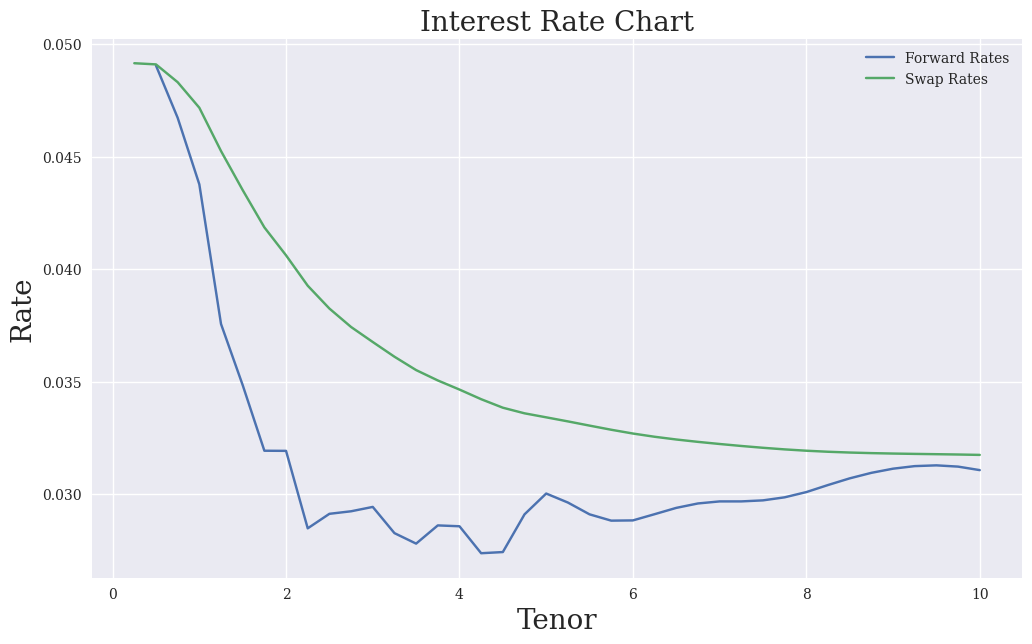

In [47]:
plt.figure(figsize=(12,7))
plt.plot(curves['forwards'], label = 'Forward Rates')
plt.plot(curves['swap rates'], label = 'Swap Rates')
plt.xlabel('Tenor',size = 20)
plt.ylabel('Rate', size = 20)
plt.title('Interest Rate Chart', size = 20)
plt.legend(loc = 0)

In [42]:
# Now Calculate The Price of the Callable Bond

option = bintree_pricing(payoff=wrapper_call,ratetree =ratetree.iloc[:tsteps, :tsteps],undertree=clean_tree,style='american')
option.head()

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00
state,,,,,,,,,,,,,,,,,,,,,
0,11.716547,9.255937,7.021568,5.113205,3.543357,2.325681,1.432885,0.821523,0.433508,0.205833,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,14.465085,11.742282,9.138886,6.851201,4.881980,3.309603,2.109214,1.257478,0.690681,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,17.503648,14.625842,11.667490,9.007876,6.607652,4.630210,3.059497,1.892751,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,20.662143,17.843281,14.541600,11.598088,8.746248,6.346053,4.337944,...,0.000013,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,22.555436,20.275893,17.662899,14.613842,11.305188,8.488253,...,0.001518,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.3 Callable Bond

One important difference between Treasury debt and this bond is that this bond is **callable**
* Furthermore, this bond is callable with **American** style--it can be called any quarter.
* Strike is 100.
* Note that the holder of the bond is short this call option; (the issuer has the optionality.) 

**Use the BDT model to price this implicit American call option and the resulting callable bond.**
* Note that the price of the callable bond is your answer to the previous question minus this American option.
* How close is the modeled price to the market quoted price now? 

#### Caution on coupons
* Be careful in modeling the underlying for the American option.
* In pricing the bond in the previous problem, you should have considered the coupon values.
* But in pricing the option, you must account for the fact that the price drops by the coupon value at the node the coupon is paid. (That is, the tree shows the *ex-coupon* price.)
* Consider building the bond valuation tree for the problem above which incorporates the coupons, similar to the cashflow trees we used in W.2. for caps and swaps.
* But then adjust this bond value tree by subtracting the current period's coupons in order to build the underlying tree.

In [62]:
quote = 97.478
callabletree = clean_tree-option
numacc = int((T*compound)%cpn_freq)
quote_dirty = quote + numacc*(cpn/cpn_freq)*100
model_dirty = callabletree.iloc[0,0] + accintree.loc[0]
price_df = pd.DataFrame({'Modeled Prices':[callabletree.iloc[0,0],model_dirty],'Market Prices':[quote, quote_dirty]},index = ['Clean Price', "Cash Price"])
price_df

,Modeled Prices,Market Prices
Clean Price,95.168417,97.4780
Cash Price,96.262167,99.6655


In [63]:
import seaborn as sns

<AxesSubplot:xlabel='time', ylabel='state'>

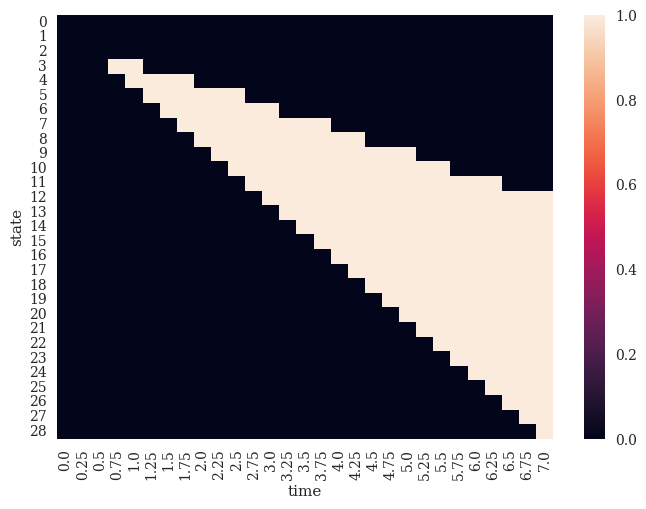

In [64]:
sns.heatmap(exercise_decisions(payoff=wrapper_call,undertree=clean_tree,derivtree=option))